In [10]:
import math
import numpy as np
import tqdm 
import torch 
import random
import matplotlib.pyplot as plt
%matplotlib inline
 

In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [12]:
class Value : 
    def __init__(self,data,_children =(),_op='',label=''):
        self.data = data   
        self.grad = 0.0 
        self._backward = lambda : None # empty funtion if it makes sense saying it this way
        self._prev = set(_children)  
        self._op = _op 
        self.label = label 

    def __repr__(self): 
        return f"Value(data={self.data})"   

    def __add__(self,next):   
        next = next if isinstance(next, Value) else Value(next) 
        ret = Value(self.data+next.data,(self,next),'+')  
        # adding constant

        ''' 
            f = a + b 
            df/da  = 1  , df/db = 1 
        '''
        def _backward():   
            self.grad += 1.0*ret.grad # chain rule we keep changes instead of setting/assigning 
            next.grad += 1.0*ret.grad 
        
        ret._backward = _backward 
        #print(ret)
        return ret   
    
    def __mul__(self,next):  
        next = next if isinstance(next,Value) else Value(next)
        
        ''' 
            f = a * b 
            df/da  = b  , df/db = a 
        '''
       
        ret = Value(self.data*next.data,(self,next),'*')  
       
        def _backward() : 
            self.grad += next.data * ret.grad
            next.grad += self.data * ret.grad 
            print()
        
        ret._backward = _backward
        return ret 

    def __neg__(self) : 
        return self*-1
    
    def __sub__(self,next) : 
        return self + (-next)

    def __rmul__(self,next) :    
        return self*next  

    def __radd__(self,next) :
        return self+next 

    def tanh(self):  

        ''' 
            f = tanh(x) 
            df/dx = 1 - tanh(x)*tanh(x)

        '''
        x = self.data
        ret = (math.exp(2*x) - 1) / (math.exp(2*x) + 1) 
        out = Value(ret,(self,),'tanh')  
        def _backward(): 
            self.grad += (1 - ret**2)*out.grad 
        
        out._backward = _backward
        return out 

    def __pow__(self,next) : 
        assert (isinstance(next,(int,float))) # only ints and floats  
        x = self.data
        out = Value(x**next,(self,),f'**{next}') 
        def _backward() :
            self.grad += out.grad *next* (self.data**(next-1)) 
        out._backward = _backward

        return out
    
    def __truediv__(self,next):
        return self*(next**-1)
    
    def exp(self) : 
        x = self.data
        out = Value(math.exp(x),(self,), 'exp')  
        def _backward() : 
            self.grad += out.data*out.grad 
        out._backward = _backward 
        return out


    def backward(self):    
        ord = []
        vis = set() 
        # do a topological sort
        def dfs(v): 
            if v not in vis:   
                vis.add(v)
                for u in v._prev :  
                    dfs(u)
                ord.append(v) 
        
        dfs(self)  
        print(ord)
        self.grad = 1.0 
        #print(ord)

        #  call backward for each node in topological order 
        for i in reversed(ord) : 
            i._backward()

In [73]:
# an example of a single neuron 

class Neuron :  
    def __init__(self,nin): # number of inputs 
        # init wt and bais 
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1)) 

    def __call__(self,x): # returns n(x)   
        activation = sum((wi*xi for wi,xi in zip(self.w,x)),self.b) 
        out = activation.tanh()
        return out

    def parameters(self) : 
        return self.w + [self.b]



class Layer: 
    def __init__(self,nin,nout) :
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):  
        outs = [n(x) for n in self.neurons] 
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self): 
        return [p for layer in self.layers for p in layer.parameters()]

In [99]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1]) 
n(x)

Value(data=-0.39521085569604797)

In [100]:
n.parameters()
len(n.parameters())
n.layers[0].neurons[0].w[0].grad,n.layers[0].neurons[0].w[0].data

(0.0, 0.1950030314965363)

In [101]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [108]:
for k in range(30):
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) 


  #### flush flush flush  

  for p in n.parameters():
    p.grad = 0.0

  loss.backward()
  #update 
  for p in n.parameters(): 
    p.data+= -0.05 * p.grad    

  print(k,loss.data)

[Value(data=-1.0), Value(data=-0.060636354306732525), Value(data=1.0), Value(data=-0.060636354306732525), Value(data=-0.4945306509358909), Value(data=1.03263384209821), Value(data=1.0), Value(data=1.03263384209821), Value(data=0.5381031911623191), Value(data=0.47746683685558655), Value(data=-1.0), Value(data=-0.1720110114832567), Value(data=0.1720110114832567), Value(data=0.6494778483388433), Value(data=0.5713183520827144), Value(data=0.4651734240098269), Value(data=0.2657621140379681), Value(data=0.3898883886496083), Value(data=1.0), Value(data=0.3898883886496083), Value(data=-1.0363385347234653), Value(data=-0.646450146073857), Value(data=1.0), Value(data=0.8265635141974254), Value(data=0.8265635141974254), Value(data=0.18011336812356837), Value(data=-1.0), Value(data=-0.7529841790968512), Value(data=0.7529841790968512), Value(data=0.9330975472204196), Value(data=0.7320348080003102), Value(data=-0.7147811882146954), Value(data=-0.5232447098769781), Value(data=-1.0), Value(data=0.3740

In [109]:
ypred 

[Value(data=0.9808132308953115),
 Value(data=-0.95824369643649),
 Value(data=-0.9542726629665774),
 Value(data=0.9532467056476583)]

In [91]:
loss.backward()

[Value(data=-0.0754875789354883), Value(data=-0.2976019988480226), Value(data=0.29413470695181115), Value(data=1.0), Value(data=0.29413470695181115), Value(data=0.6880032340646347), Value(data=0.05184910961471892), Value(data=1.0), Value(data=0.05184910961471892), Value(data=0.7398523436793536), Value(data=1.0339870506311648), Value(data=0.7755024824795091), Value(data=-0.23079108889750552), Value(data=0.30150684898787905), Value(data=1.0), Value(data=0.30150684898787905), Value(data=1.0), Value(data=0.8168270523204256), Value(data=0.8168270523204256), Value(data=0.9281476918855137), Value(data=1.7449747442059393), Value(data=2.0464815931938185), Value(data=0.96716853644561), Value(data=-0.02876070206250619), Value(data=-0.027816446120942348), Value(data=-0.5913108776576644), Value(data=1.0), Value(data=-0.4365846672445498), Value(data=-0.4365846672445498), Value(data=0.7073245043895859), Value(data=1.0), Value(data=0.18487072984500855), Value(data=0.18487072984500855), Value(data=0.89

In [92]:
for p in n.parameters(): 
  p.data+= -0.01 * p.grad          # gd update LR * grad


n.layers[0].neurons[0].w[0].grad,n.layers[0].neurons[0].w[0].data

(-0.4568315758614132, 0.1674273735190444)

In [93]:
xs,ys  
ypred

[Value(data=0.06333307511445276),
 Value(data=-0.11524252587108703),
 Value(data=0.003147918765422929),
 Value(data=-0.009932887286495811)]

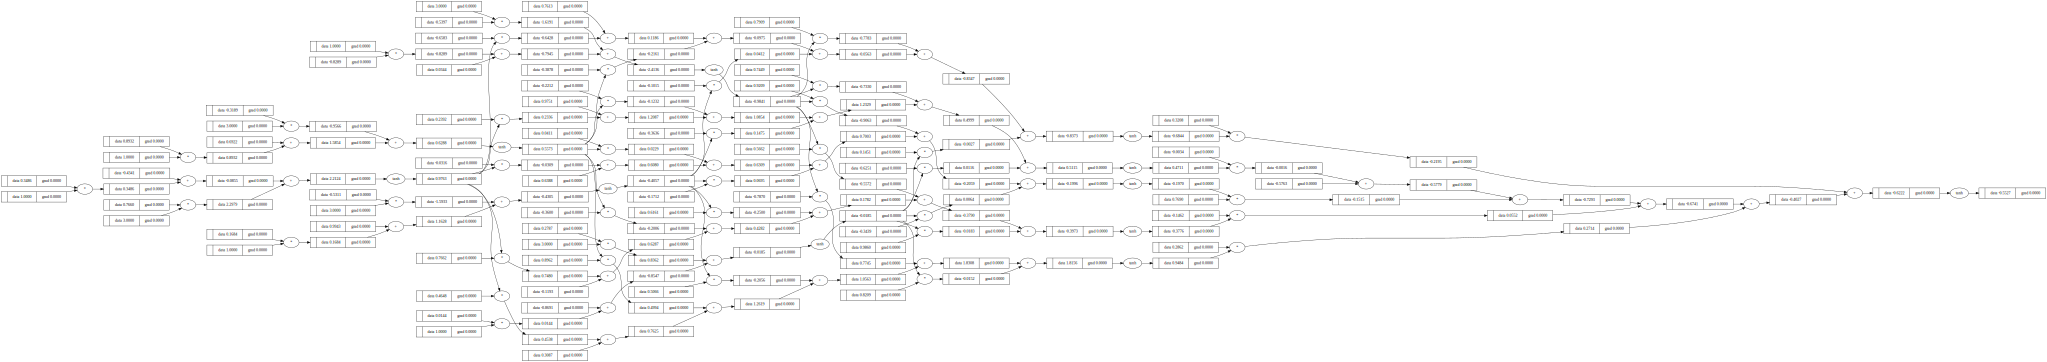

In [42]:
draw_dot(n(x))